In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
import numpy as np
import math 
import rfpimp

# Modelling Footfall

This code analyses how retail footfall responds to a range of factors, including **baseline activity levels**, **retail centre characteristics**, **temporal effects**, and, of course, **weather conditions**.

### Workflow Overview
1. **Data Preparation**  
   - Import and clean retail area data  
   - Check for missing weather values  
   - Encode categorical variables for modeling  

2. **Model Development**  
   - Build Random Forest models to predict footfall  
   - Start with baseline features (location means + CACI indicators)  
   - Incrementally add temporal and weather variables  

3. **Model Evaluation**  
   - Use cross-validation (R² and RMSE) to assess performance  
   - Extract and visualise feature importance  

4. **Retail-Type Analysis**  
   - Fit models by retail typology  
   - Explore variation in sensitivity to temporal and weather effects  

5. **Scenario Simulation**  
   - Estimate footfall changes under different temperature scenarios  
   - Compare impacts across locations and retail types  

6. **Spatial Visualisation**  
   - Map predicted changes to reveal geographic patterns  

This approach provides a view of the drivers of retail footfall and their relative influence, with a focus on the impact of weather on footfall.


Let's first get set up...

In [2]:
retail_areas = pd.read_csv("retail_areas_final.csv")

Double check our retail areas:

In [ ]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1207
Total number of rows: 437686


We also want to check the missing wind data to make sure dates are not confined to specific times of the year, potenitally biasing results:

In [5]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

## 1.1. Model Prep

It was necessary to select a modelling approach that fits the data. As a start, we see how weather and footfall relate to one another, before creating a model dataframe with encoded variables.

### 1.1.1. Check for linear relationships

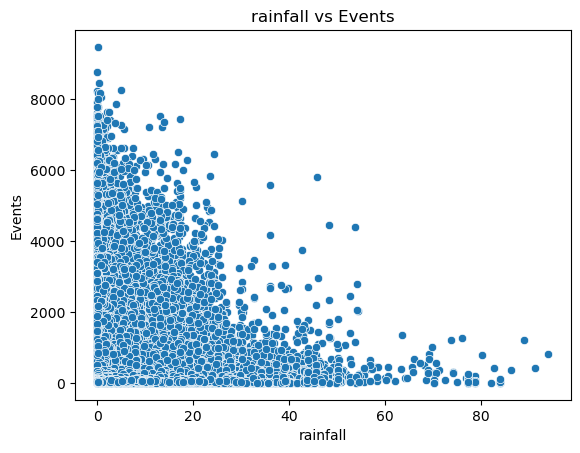

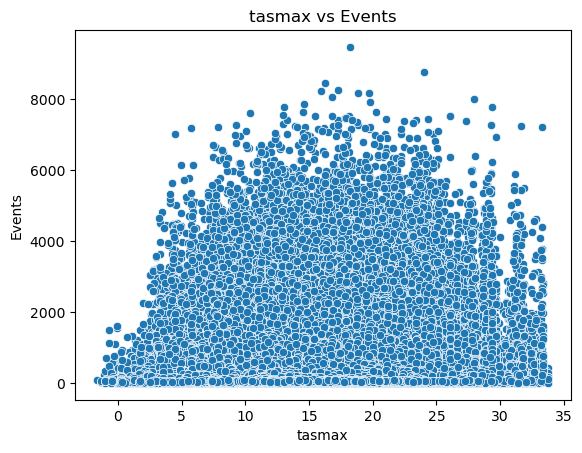

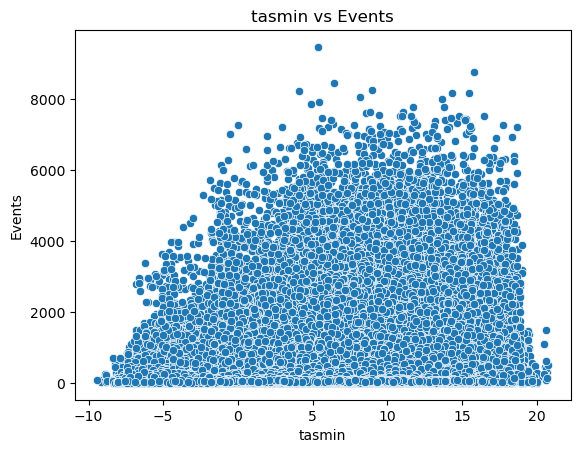

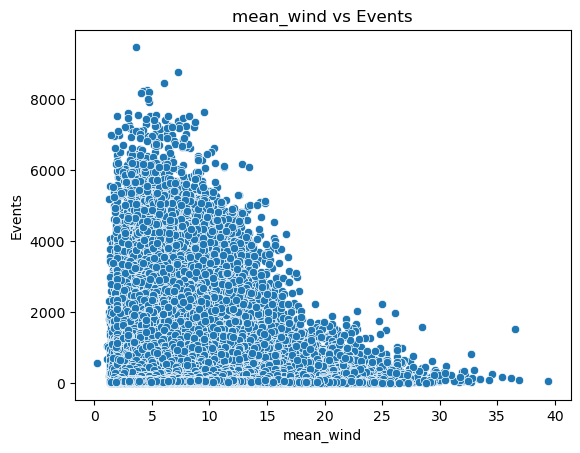

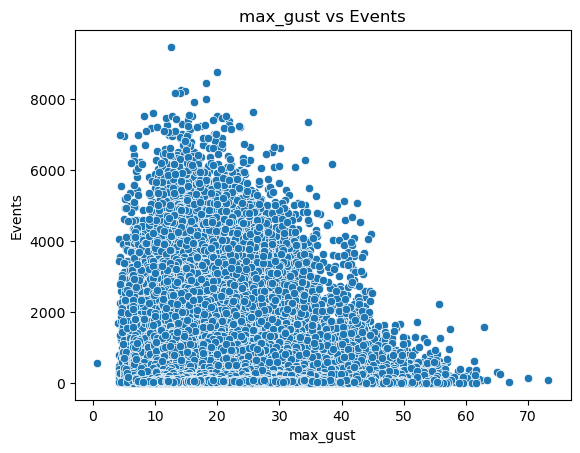

In [ ]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

Non-linear and threshold effects are clearly visible in the exploratory plots, indicating that footfall responses to weather and temporal factors are not strictly linear.  

This makes **Random Forest regression** a suitable choice, as it can capture complex, non-linear relationships and interactions between variables without requiring explicit assumptions.


### 1.1.2. Variable encoding

Now, let's get the data ready for the models by one-hot encoding categorical variables:

In [3]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=False)

# define weather variables
weather_vars = ['rainfall', 'tasmax', 'mean_wind']

# calculate mean annual footfall for each location
location_means = df_model.groupby('Local_Footprint_Centre_ID')['events'].mean().rename('location_mean_footfall')
# merge back to dataframe
df_model = df_model.merge(location_means, on='Local_Footprint_Centre_ID')

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score                680
Major_Class_Name             729
Minor_Class_Name             729
Seasonality_Class_Name       729
rainfall                    3976
tasmax                      3976
tasmin                      3976
mean_wind                 132578
max_gust                  132578
dtype: int64
Rows with at least one missing value: 136340
Total rows before drop: 437686
Total rows after drop: 301346


We're ready to begin the modelling process.

## 2.1. All-Retail Models

At this stage, we aim to explore how weather impacts footfall overall.

This is done by comparing model performance with and without weather variables, assessing whether their inclusion improves predictive accuracy. Footfall remains the dependent variable across all model iterations.

The modelling approach is **iterative**:
1. Start with a basic model including only location average footfall and CACI location scores.
2. Introduce temporal features (e.g., weekends, holidays, seasons).
3. Finally, incorporate weather variables to explore their additional explanatory power.

This stepwise approach helps isolate the contribution of different factors while maintaining interpretability of the model's performance improvements.

### 2.1.1. Most basic (baseline + CACI indicators)

We start with the most basic model, which we will build upon. Location average footfall, residential population, and Leisure, Retail, and Tourism scores are included. 

Set up:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score'
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1173
2024-01-16    1177
2024-01-17    1170
2024-01-18    1176
2024-01-19    1178
              ... 
2024-11-20    1181
2024-11-25    1182
2024-11-26    1179
2024-11-27    1184
2024-12-02    1181
Name: id, Length: 255, dtype: int64


Calibrate hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=20, min_samples_split=8; total time=  13.0s
[CV] END .................max_depth=20, min_samples_split=10; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=4; total time=  13.0s
[CV] END .................max_depth=30, min_samples_split=10; total time=  13.0s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  13.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  14.2s
[CV] END ..................max_depth=40, min_samples_split=4; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  13.0s
[CV] END ..................max_depth=50, min_samples_split=2; total time=  13.1s
[CV] END .................max_depth=40, min_samples_split=10; total time=  13.0s
[CV] END .................max_depth=40, min_samples_split=10; total time=  13.4s
[CV] END ..................m

Implement random forest:

In [ ]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [ ]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9042 ± 0.0006
Mean Train RMSE: 194.1810 ± 0.2832
Mean Test R²: 0.9031 ± 0.0025
Mean Test RMSE: 195.2197 ± 1.1159


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.811161
Tourism Score                                  0.001206
Leisure_Footprint_Score                        0.000522
Retail Footprint Score                         0.000092
Residential Population (Weighted Catchment)   -0.000502


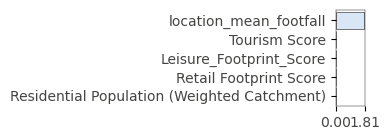

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.2. Add temporal vars

Now, in the second step, we add temporal variables. These include season, weekend, and holiday identifiers. 

Set up:

In [4]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Calibrate hyperparameters:

In [5]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time=  24.7s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  24.8s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.0s
[CV] END ..................m

Implement random forest:

In [6]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [7]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9434 ± 0.0005
Mean Train RMSE: 149.2551 ± 0.3986
Mean Test R²: 0.9362 ± 0.0024
Mean Test RMSE: 158.3101 ± 1.6639


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.747631
season_Autumn                                  0.016981
season_Summer                                  0.011149
weekend                                        0.009355
season_Spring                                  0.006930
season_Winter                                  0.006663
Leisure_Footprint_Score                        0.004655
Residential Population (Weighted Catchment)    0.003600
Tourism Score                                  0.001811
Retail Footprint Score                         0.001676
holiday                                        0.001185


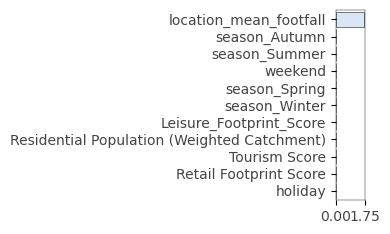

In [8]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.3. Add weather vars

Finally, we add in weather variables. 

Set up:

In [10]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Calibrate hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.2min
[CV] END ..................max_depth=10, min_sa

Implement random forest:

In [11]:
rf_general_weather = RandomForestRegressor(max_depth=20, 
                                 min_samples_split=10, 
                                 random_state=10000)
rf_general_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Sample tree to see how things are looking behind the scenes:

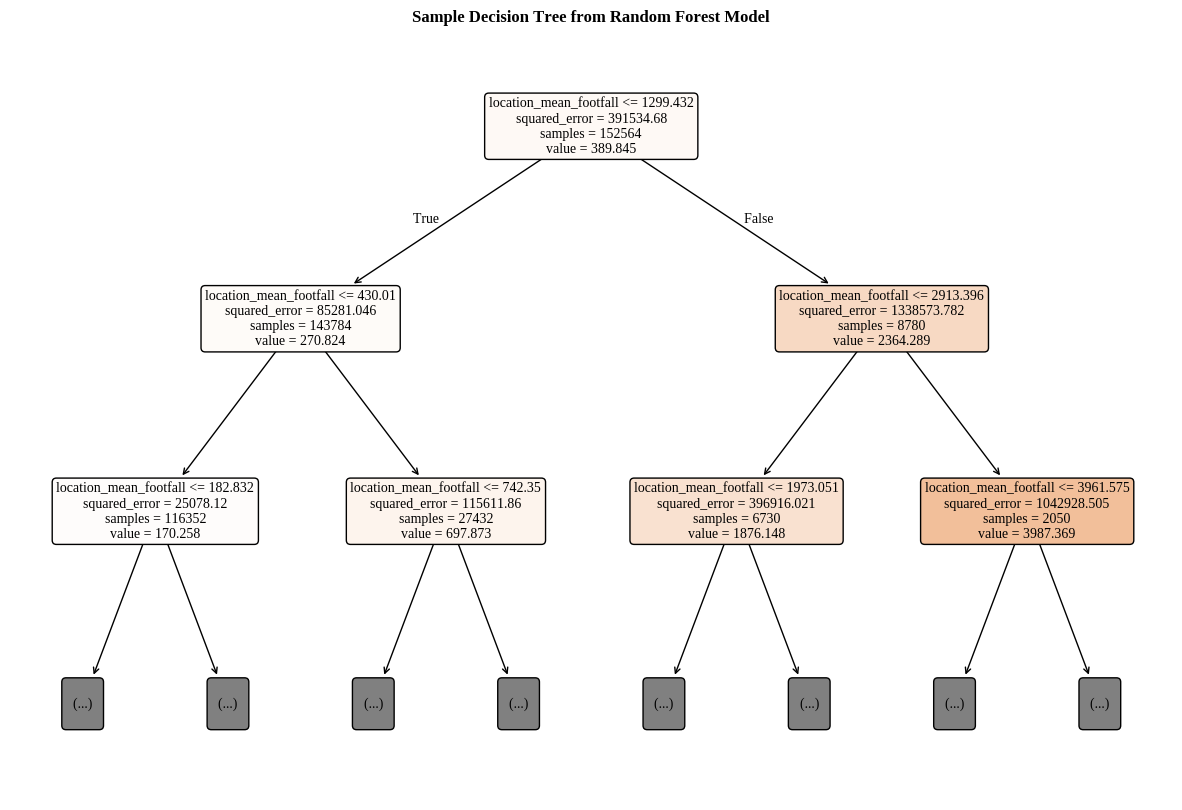

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(rf_general_weather.estimators_[0], 
          feature_names=train_x.columns.tolist(), 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=2)  # limit depth during plotting

plt.title('Sample Decision Tree from Random Forest Model', fontweight='bold')

fig= plt.gcf()  # get the current figure
fig.savefig('tree.png', dpi=500, bbox_inches='tight')

plt.show()

Cross-validated performance:

In [7]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_general_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9726 ± 0.0003
Mean Train RMSE: 103.8875 ± 0.2288
Mean Test R²: 0.9376 ± 0.0021
Mean Test RMSE: 156.6046 ± 1.4393


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.862759
season_Autumn                                  0.022449
season_Summer                                  0.012742
season_Winter                                  0.011248
weekend                                        0.008629
tasmax                                         0.007299
season_Spring                                  0.005955
Tourism Score                                  0.004241
Leisure_Footprint_Score                        0.004121
mean_wind                                      0.002481
Retail Footprint Score                         0.002463
rainfall                                       0.002111
Residential Population (Weighted Catchment)    0.001580
holiday                                        0.000591


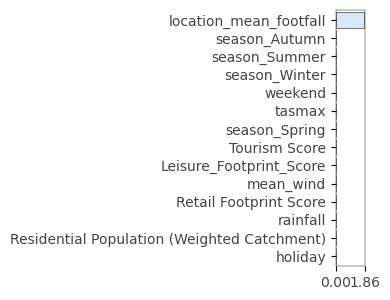

In [9]:
imp = rfpimp.importances(rf_general_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

We see model performance improves with the addition of weather, with some caveats. There is a divergence between train- and test-set R2 when weather variables are added, indicating that noise has been introduced into the model and it does not perform as well on unseen data compared to that it has been trained on. 

This makes sense- the impact of weather is expected to be context-dependent, with different types of places reacting differently. So, in the next step, we model footfall per retail centre type to explore these dynamics in greater detail. 

## 2.2. Models per Retail Type

At this stage, the analysis shifts from an all-retail perspective to **retail-type specific models**.  
The goal is to capture differences in how various retail typologies respond to retail centre characteristics, temporal patterns, and weather effects.

Key steps include:
- Train separate Random Forest models for each retail type.  
- Tune hyperparameters individually to reflect type-specific data characteristics.  
- Evaluate model performance using repeated cross-validation.  
- Analyse feature importance and generate partial dependence plots to visualise how weather variables influence footfall across different retail environments.

In doing this, we can get some insight into the differential impact of weather depending on the type of retail centre. 

Set up:

In [7]:
group_col = 'groupName'
randomState_dt = 10000

# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'Tourism Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

In [5]:
# Capitalize the first letter of each word in 'groupName'
df_model['groupName'] = df_model['groupName'].str.title()

# Check the updated DataFrame
print(df_model[['groupName']])

                                                groupName
0       Primary Shopping Centres And Premium Destinations
8       Primary Shopping Centres And Premium Destinations
9       Primary Shopping Centres And Premium Destinations
12      Primary Shopping Centres And Premium Destinations
13      Primary Shopping Centres And Premium Destinations
...                                                   ...
437675                                 Indie High Streets
437676                                 Indie High Streets
437677                                 Indie High Streets
437678                                 Indie High Streets
437685                                 Indie High Streets

[301346 rows x 1 columns]


Calibrate, cross-validate and plot partial dependence:


Group: District Urban Service Centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.983 ± 0.000
Train RMSE: 124.226 ± 0.451
Test R²: 0.956 ± 0.001
Test RMSE: 199.164 ± 3.216
Feature Importances:
location_mean_footfall                         0.932
tasmax                                         0.011
season_Autumn                                  0.011
mean_wind                                      0.008
rainfall                                       0.007
season_Summer                                  0.007
weekend                                        0.005
Leisure_Footprint_Score                        0.004
Retail Footprint Score                         0.004
Residential Population (Weighted Catchment)    0.003
Tourism Score                                  0.002
season_Winter                                  0.002
season_Spring                                  0.002
holiday                                        0.001
dtype: float6

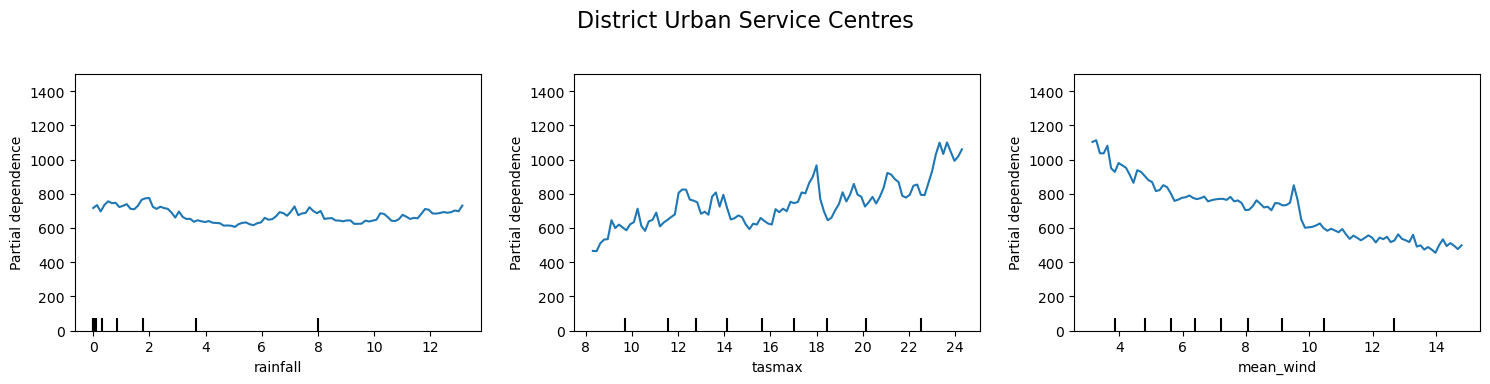


Group: Indie High Streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.941 ± 0.001
Train RMSE: 101.861 ± 0.554
Test R²: 0.855 ± 0.004
Test RMSE: 159.502 ± 2.856
Feature Importances:
location_mean_footfall                         0.844
tasmax                                         0.034
mean_wind                                      0.028
rainfall                                       0.023
season_Autumn                                  0.016
season_Summer                                  0.009
Tourism Score                                  0.008
weekend                                        0.008
Retail Footprint Score                         0.007
Residential Population (Weighted Catchment)    0.007
Leisure_Footprint_Score                        0.007
season_Winter                                  0.005
season_Spring                                  0.003
holiday                                        0.001
dtype: float64


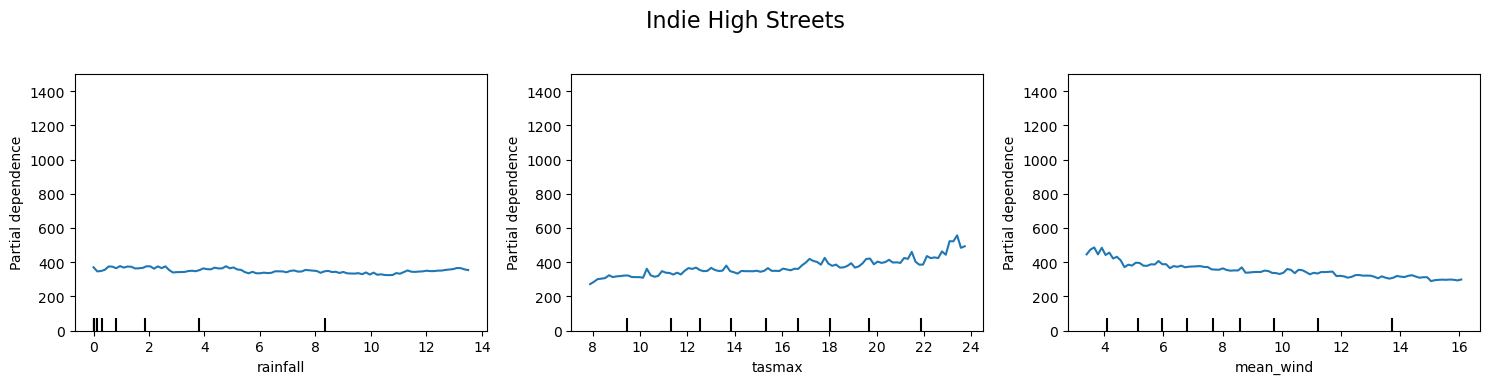


Group: Large Regional Retail And Leisure Destinations
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.967 ± 0.000
Train RMSE: 76.158 ± 0.330
Test R²: 0.922 ± 0.004
Test RMSE: 117.890 ± 1.789
Feature Importances:
location_mean_footfall                         0.901
tasmax                                         0.017
mean_wind                                      0.015
Leisure_Footprint_Score                        0.013
weekend                                        0.013
rainfall                                       0.012
season_Autumn                                  0.007
Tourism Score                                  0.005
Residential Population (Weighted Catchment)    0.005
Retail Footprint Score                         0.004
holiday                                        0.003
season_Summer                                  0.002
season_Winter                                  0.002
season_Spring                                  0.00

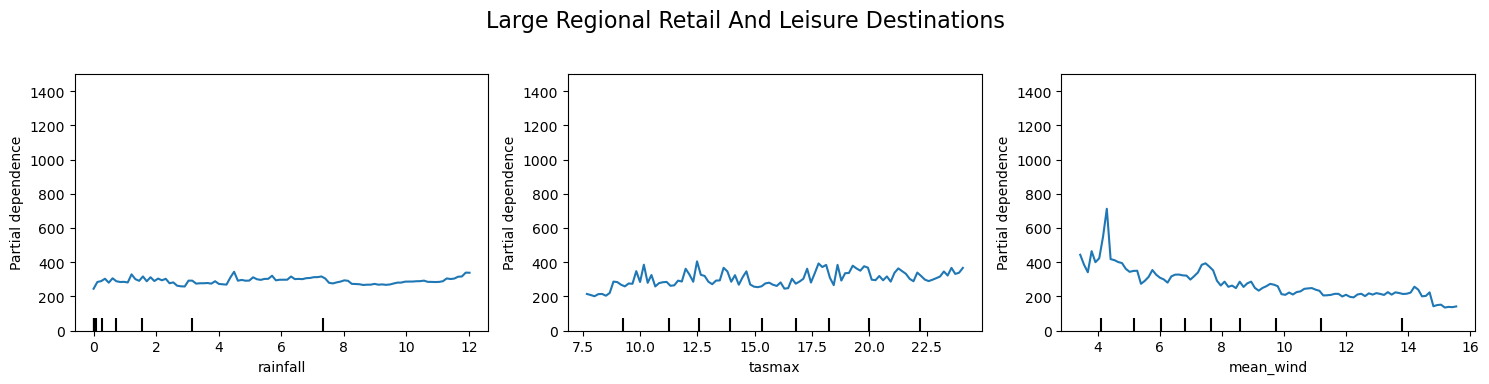


Group: Local Urban Convenience Centres
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.958 ± 0.001
Train RMSE: 147.571 ± 1.454
Test R²: 0.930 ± 0.006
Test RMSE: 191.492 ± 7.757
Feature Importances:
location_mean_footfall                         0.872
Residential Population (Weighted Catchment)    0.028
Tourism Score                                  0.025
season_Autumn                                  0.018
tasmax                                         0.015
season_Summer                                  0.011
mean_wind                                      0.009
rainfall                                       0.007
Leisure_Footprint_Score                        0.005
weekend                                        0.003
Retail Footprint Score                         0.003
season_Winter                                  0.002
season_Spring                                  0.001
holiday                                        0.000
dtype: float

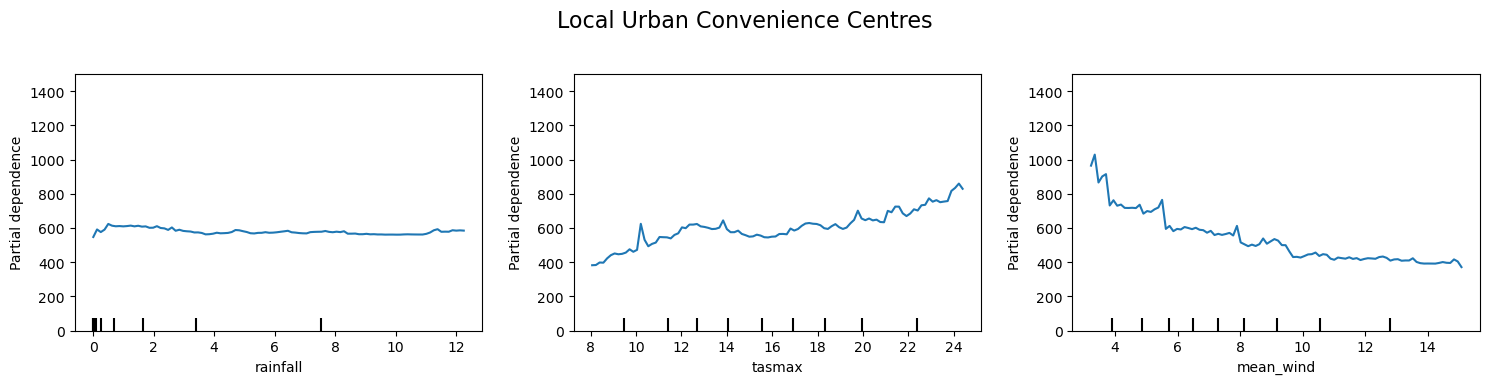


Group: Mass And Value High Streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.963 ± 0.001
Train RMSE: 99.062 ± 0.524
Test R²: 0.905 ± 0.008
Test RMSE: 157.134 ± 3.253
Feature Importances:
location_mean_footfall                         0.815
Residential Population (Weighted Catchment)    0.031
Tourism Score                                  0.026
tasmax                                         0.022
Retail Footprint Score                         0.022
Leisure_Footprint_Score                        0.022
mean_wind                                      0.019
rainfall                                       0.015
season_Autumn                                  0.010
weekend                                        0.006
season_Summer                                  0.006
season_Winter                                  0.004
season_Spring                                  0.002
holiday                                        0.001
dtype: float64


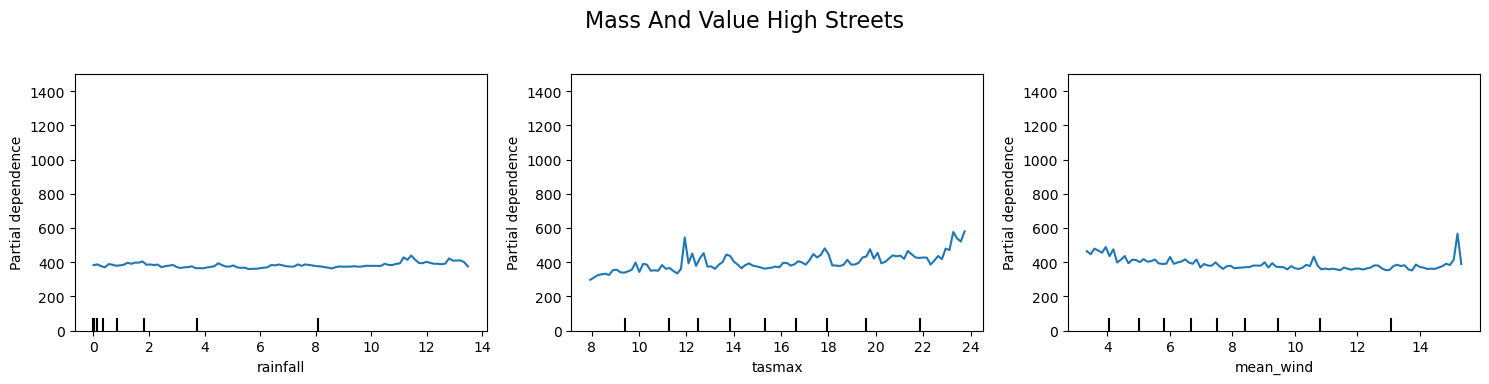


Group: Primary Shopping Centres And Premium Destinations
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.920 ± 0.004
Train RMSE: 108.773 ± 2.291
Test R²: 0.811 ± 0.027
Test RMSE: 166.445 ± 10.267
Feature Importances:
location_mean_footfall                         0.425
Retail Footprint Score                         0.361
tasmax                                         0.056
mean_wind                                      0.032
weekend                                        0.029
rainfall                                       0.023
Leisure_Footprint_Score                        0.022
season_Summer                                  0.012
season_Autumn                                  0.009
Residential Population (Weighted Catchment)    0.009
Tourism Score                                  0.007
season_Winter                                  0.006
holiday                                        0.006
season_Spring                                 

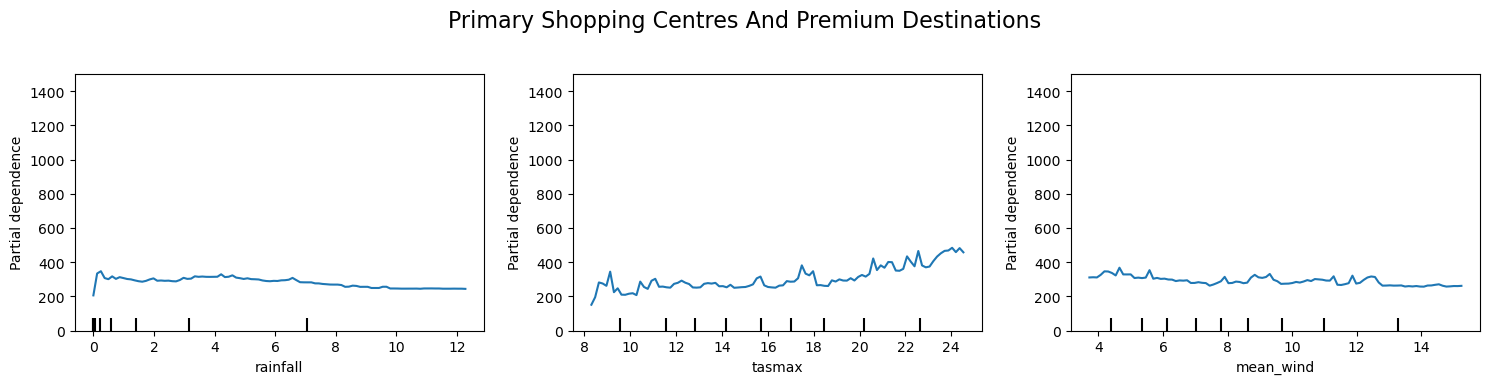


Group: Secondary Retail Parks And Shopping Centres
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.911 ± 0.002
Train RMSE: 124.391 ± 1.215
Test R²: 0.849 ± 0.012
Test RMSE: 161.925 ± 6.822
Feature Importances:
location_mean_footfall                         0.851
tasmax                                         0.023
season_Autumn                                  0.022
season_Summer                                  0.020
mean_wind                                      0.019
season_Winter                                  0.014
season_Spring                                  0.013
rainfall                                       0.013
weekend                                        0.007
Retail Footprint Score                         0.006
Residential Population (Weighted Catchment)    0.005
Tourism Score                                  0.004
Leisure_Footprint_Score                        0.004
holiday                                        0.001


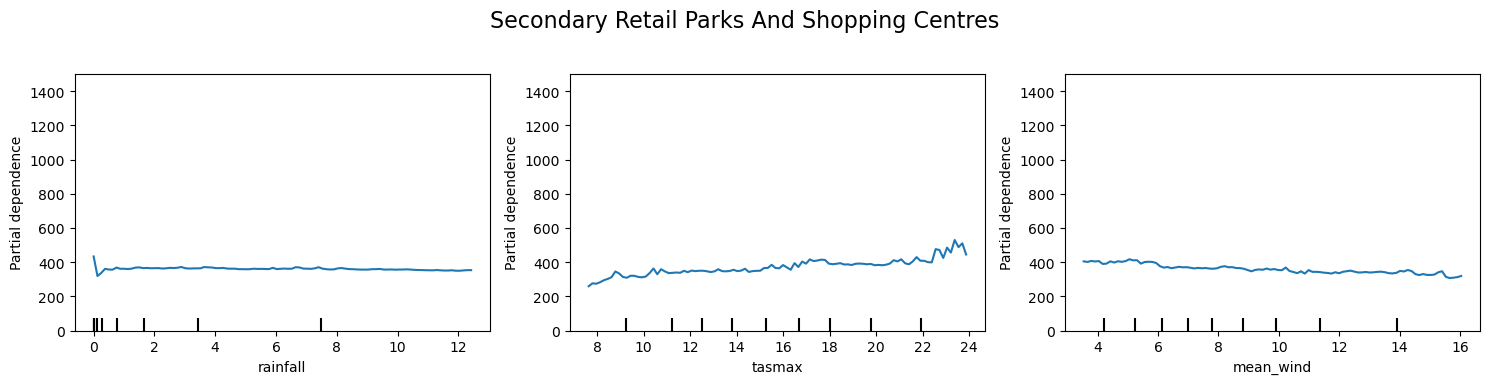


Group: Sub-Regional Retail And Leisure Destinations
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.982 ± 0.000
Train RMSE: 100.357 ± 0.597
Test R²: 0.956 ± 0.002
Test RMSE: 159.752 ± 3.338
Feature Importances:
location_mean_footfall                         0.939
tasmax                                         0.011
mean_wind                                      0.009
Tourism Score                                  0.007
rainfall                                       0.007
Leisure_Footprint_Score                        0.005
season_Winter                                  0.005
season_Autumn                                  0.004
season_Spring                                  0.004
season_Summer                                  0.003
weekend                                        0.003
Retail Footprint Score                         0.002
Residential Population (Weighted Catchment)    0.002
holiday                                        0.001

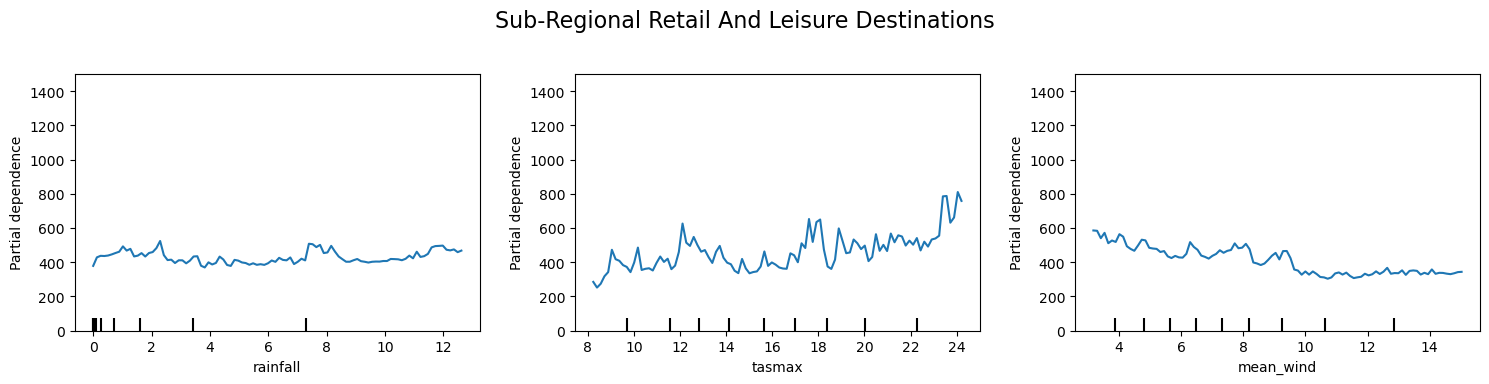

In [8]:
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split features/target
    X = group_data[features]
    y = group_data[target]

    # split into train/test
    train_x, test_x, train_y, test_y = train_test_split(
        X, y,
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 4, 6, 8, 10]
    }
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    best_params = clf.best_params_
    print(f"\nGroup: {name}")
    print("Best parameters:", best_params)

    # cross-validation on full group
    model = RandomForestRegressor(random_state=randomState_dt, **best_params)
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    cv_results = cross_validate(
        model,
        X, y,
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize CV metrics
    def summarize(metric):
        mean_val = np.mean(cv_results[f'train_{metric}'])
        std_val = np.std(cv_results[f'train_{metric}'])
        mean_test = np.mean(cv_results[f'test_{metric}'])
        std_test = np.std(cv_results[f'test_{metric}'])
        return mean_val, std_val, mean_test, std_test

    train_r2, std_train_r2, test_r2, std_test_r2 = summarize('r2')
    train_rmse, std_train_rmse, test_rmse, std_test_rmse = summarize('rmse')
    train_rmse, test_rmse = -train_rmse, -test_rmse  # invert negative RMSE

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {test_rmse:.3f} ± {std_test_rmse:.3f}")

    # final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)
    print("Feature Importances:")
    print(importances.round(3))

    # partial Dependence Plots for weather_vars
    X_weather = group_data[weather_vars].copy()
    model_weather = RandomForestRegressor(random_state=randomState_dt, **best_params).fit(X_weather, y)

    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    PartialDependenceDisplay.from_estimator(
        model_weather,
        X_weather,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional

    plt.suptitle(f'{name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save the plot to a file
    plt.savefig(f'{name}_partial_dependence_plot.png',  dpi=400)

    plt.show()

## 2.3. Temperature Simulation

Finally, while previous modelling steps show that different retail types respond differently to weather, they do not reveal **which specific locations are most sensitive**. 
 
To explore this, we simulate changes in footfall under different temperature scenarios.

Temperature was chosen as the key weather variable because it consistently ranked as the most important predictor across all retail types.  
Two reference points were selected:  
- **12 °C (25th percentile)** – representing a relatively cooler day  
- **19 °C (75th percentile)** – representing a relatively warmer day  

By holding all other variables constant and altering only temperature, we can estimate the **change in predicted footfall** between these two conditions.

This section covers:  
- **2.3.1. Predict Footfall** – generating predictions for cooler vs. warmer scenarios.  
- **2.3.2. Aggregate Sensitivity** – summarising effects by location and retail type.  
- **2.3.3. Map Results** – visualising spatial patterns of temperature sensitivity.


### 2.3.1. Predict footfall

We start by implementing the all-retail model to predicting footfall based on our temperature scenarios:

In [12]:
# use entire test set
all_idx = test_x.index
test_all = test_x.loc[all_idx]

# create copies for temperature scenarios
test_min = test_all.copy()
test_max = test_all.copy()

# tasmax column from full dataset
tasmax_all = df_model['tasmax'] 

# calculate quantiles
temp_min = tasmax_all.quantile(0.25)
temp_max = tasmax_all.quantile(0.75)

print(f"25th percentile temp: {temp_min:.1f}°C")
print(f"75th percentile temp: {temp_max:.1f}°C")

# set temperature
temp_col = 'tasmax'
test_min[temp_col] = temp_min
test_max[temp_col] = temp_max
#test_min[temp_col] = 10
#est_max[temp_col] = 15

# predict footfall
pred_min = rf_general_weather.predict(test_min)
pred_max = rf_general_weather.predict(test_max)

# compute difference
diff = pred_max - pred_min

# build results DataFrame
df_sim = test_all.copy()
df_sim['Local_Footprint_Centre_ID'] = df_model.loc[all_idx, 'Local_Footprint_Centre_ID']
df_sim['Local Footprint Name'] = df_model.loc[all_idx, 'Local Footprint Name']
df_sim['groupName'] = df_model.loc[all_idx, 'groupName']
df_sim['pred_min'] = pred_min
df_sim['pred_max'] = pred_max
df_sim['footfall_diff'] = diff
df_sim['relative_change'] = (df_sim['footfall_diff'] / df_sim['pred_min'].replace(0, np.nan)) * 100

# aggregate stats per location (all rows belonging to that location)
loc_stats = (
    df_sim.groupby('Local Footprint Name')['relative_change']
    .agg(median='median', mean='mean', std='std', count='count')
    .reset_index()
)

# merge groupName from df_sim back to loc_stats
loc_stats = loc_stats.merge(
    df_sim[['Local Footprint Name', 'groupName']].drop_duplicates(),
    left_on='Local Footprint Name',
    right_on='Local Footprint Name',
    how='left'
)

25th percentile temp: 12.0°C
75th percentile temp: 19.0°C


### 2.3.2. Aggregate sensitivity

We can extract the top ten locations that saw the greatest change in predicted footfall:

In [13]:
# show top 10 locations by mean relative change
top_mean_locs = loc_stats.sort_values('mean', ascending=False).head(10)

print("Top 10 Locations with Highest Mean Predicted Footfall Increase:")
display(top_mean_locs)

# show top 10 locations by median relative change
top_median_locs = loc_stats.sort_values('median', ascending=False).head(10)

print("Top 10 Locations with Highest Median Predicted Footfall Increase:")
display(top_median_locs)

Top 10 Locations with Highest Mean Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
373,Glasgow - St. Andrews Squ,67.949208,94.556393,69.339954,55,Large Regional Retail And Leisure Destinations
291,Edinburgh - Roxburgh Plac,62.624723,85.070588,62.863683,39,Large Regional Retail And Leisure Destinations
252,Dartmouth,57.944202,72.887614,65.023775,61,Indie High Streets
799,Padstow,60.159331,69.384779,56.749165,45,Indie High Streets
637,Looe,52.951297,66.940000,41.862504,49,Indie High Streets
336,Glasgow - Cambridge Stree,13.894314,65.273855,96.273348,50,Large Regional Retail And Leisure Destinations
201,Chesterfield - Spire Walk,52.972476,60.689136,34.568390,50,Sub-Regional Retail And Leisure Destinations
320,Fort William,59.347325,59.261332,45.449743,62,Indie High Streets
641,Loughton - Station Road,45.062330,57.427248,31.477603,28,Mass And Value High Streets
221,Colchester - Balkerne Gat,41.295870,53.632901,41.466507,43,Large Regional Retail And Leisure Destinations


Top 10 Locations with Highest Median Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
373,Glasgow - St. Andrews Squ,67.949208,94.556393,69.339954,55,Large Regional Retail And Leisure Destinations
291,Edinburgh - Roxburgh Plac,62.624723,85.070588,62.863683,39,Large Regional Retail And Leisure Destinations
799,Padstow,60.159331,69.384779,56.749165,45,Indie High Streets
320,Fort William,59.347325,59.261332,45.449743,62,Indie High Streets
252,Dartmouth,57.944202,72.887614,65.023775,61,Indie High Streets
72,Borehamwood - Fairway Ave,55.277512,50.976208,37.106425,41,Mass And Value High Streets
201,Chesterfield - Spire Walk,52.972476,60.689136,34.568390,50,Sub-Regional Retail And Leisure Destinations
637,Looe,52.951297,66.940000,41.862504,49,Indie High Streets
389,Gloucester - The Docks,50.924174,40.979109,47.253343,53,Primary Shopping Centres And Premium Destinations
885,Shanklin,49.058771,43.575765,44.069175,47,Indie High Streets


And then aggregate these results per retail type:

In [14]:
# group by groupName and compute mean/median of location-level stats
group_stats = (
    loc_stats.groupby('groupName')
    .agg(
        median=('median', 'median'),  # mean of per-location medians
        mean=('mean', 'mean'),        # mean of per-location means
        std=('mean', 'std'),          # std of per-location means
        count_locations=('count', 'sum')       # total rows (e.g. test rows) per group
    )
    .reset_index()
)

display(group_stats.sort_values('median', ascending=False))


,groupName,median,mean,std,count_locations
5,Primary Shopping Centres And Premium Destinations,8.846305,14.700327,14.434637,488
1,Indie High Streets,4.919947,9.288011,12.895850,16226
7,Sub-Regional Retail And Leisure Destinations,4.181533,7.947171,11.036736,14518
4,Mass And Value High Streets,3.750297,6.637011,10.111502,5738
2,Large Regional Retail And Leisure Destinations,3.562540,7.345731,13.236127,12690
6,Secondary Retail Parks And Shopping Centres,3.327067,7.939555,9.621475,2035
3,Local Urban Convenience Centres,1.566069,5.709783,11.142453,2142
0,District Urban Service Centres,0.683612,2.949716,7.131044,6923


Let's plot the result:

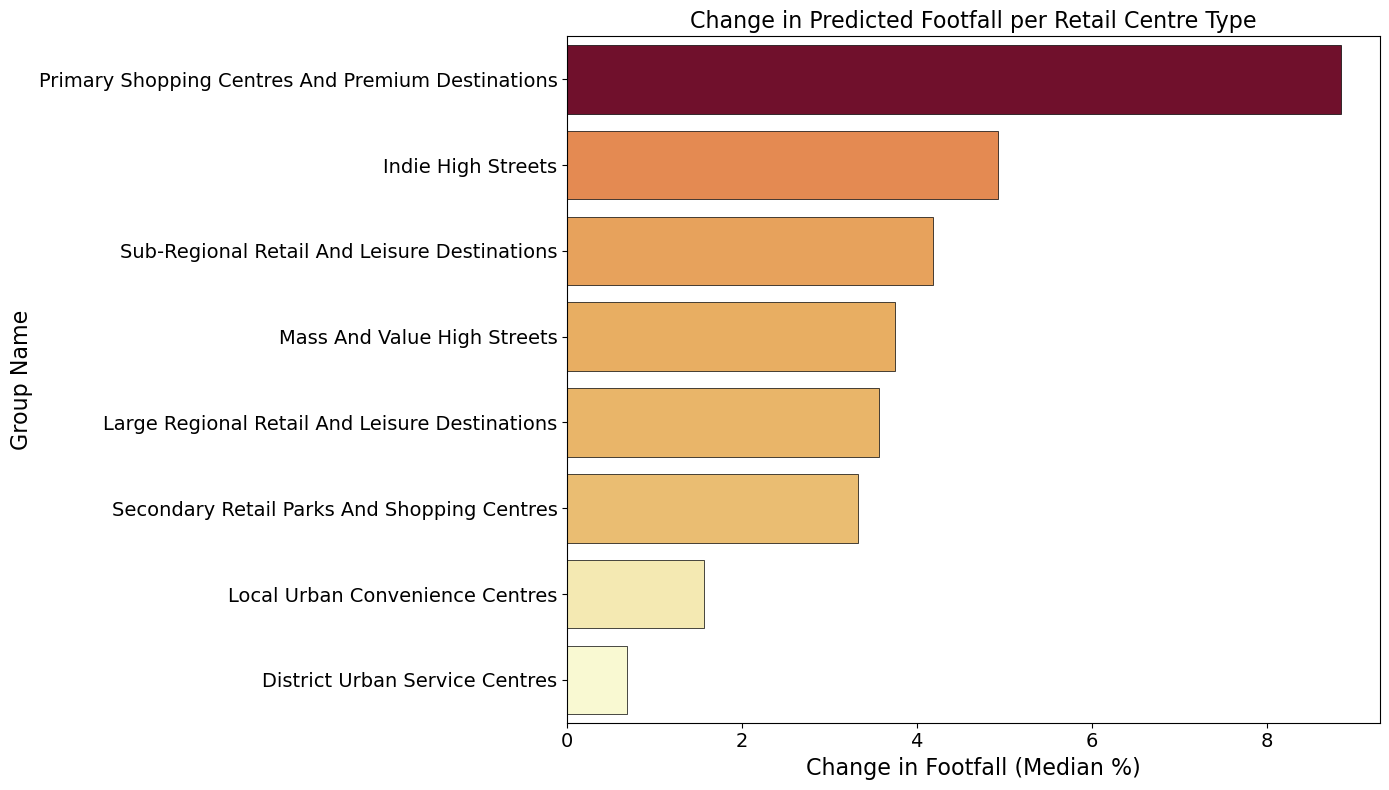

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sort by median
group_stats_sorted = group_stats.sort_values(by='median', ascending=False)

# capitalize the first letter of each word in 'groupName'
group_stats_sorted['groupName'] = group_stats_sorted['groupName'].str.title()

# melt to long format
df_melted = group_stats_sorted.melt(
    id_vars='groupName',
    value_vars=['median'],
    var_name='stat_type',
    value_name='relative_change'
)

# sreate figure and axis for the plot
fig, ax = plt.subplots(figsize=(14, 8))

# barplot with customized color palette and outline
sns.barplot(
    data=df_melted,
    y='groupName',
    x='relative_change',
    hue='relative_change',
    order=group_stats_sorted['groupName'],
    palette='YlOrRd',  # change this to any desired palette
    edgecolor='black',  # set the color of the bar outline
    linewidth=0.5       # set the thickness of the outline
)

# labels and styling with larger text
plt.title('Change in Predicted Footfall per Retail Centre Type', fontsize=16)
plt.xlabel('Change in Footfall (Median %)', fontsize=16)
plt.ylabel('Group Name', fontsize=16)

# increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# adjust the layout to make sure text fits properly
plt.tight_layout()

# remove the legend frame
plt.legend('', frameon=False)

# get the current figure and save it
fig = plt.gcf()
fig.savefig('bars.png', dpi=500, bbox_inches='tight')

plt.show()


### 2.3.3. Map results

Finally, we can map our results to visualise any geographic patterns. 

We need to create a geodataframe:

In [62]:
gdf_map = retail_areas.merge(loc_stats, on='Local Footprint Name', how='left')

In [32]:
from shapely import wkt

gdf_map['geometry'] = gdf_map['geometry'].apply(wkt.loads)
print(type(gdf_map.geometry.iloc[0]))
print(gdf_map.geometry.head())

<class 'shapely.geometry.multipolygon.MultiPolygon'>
0    MULTIPOLYGON (((0.2833716834505971 51.47871162...
1    MULTIPOLYGON (((0.2833716834505971 51.47871162...
2    MULTIPOLYGON (((0.2833716834505971 51.47871162...
3    MULTIPOLYGON (((0.2833716834505971 51.47871162...
4    MULTIPOLYGON (((0.2833716834505971 51.47871162...
Name: geometry, dtype: object


Then extract the centroids and ensure CRS is appropriate:

In [33]:
gdf_map = gpd.GeoDataFrame(gdf_map, geometry='geometry', crs='EPSG:4326')
gdf_map = gdf_map.to_crs('EPSG:27700')

In [34]:
gdf_map['centroid'] = gdf_map.geometry.centroid
gdf_centroids = gpd.GeoDataFrame(gdf_map, geometry='centroid', crs=gdf_map.crs)

In [35]:
display(gdf_map.columns)

Index(['date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local Footprint Name', 'Region', 'Base Score',
       'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Tourism Score', 'Local_Footprint_Centre_ID',
       'Local_Footprint_Centre_Name', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       '

In [36]:
print(gdf_centroids['median'].head())
print(gdf_centroids['median'].describe())
print(gdf_centroids['median'].isna().sum())

0    8.846305
1    8.846305
2    8.846305
3    8.846305
4    8.846305
Name: median, dtype: float64
count    436684.000000
mean          4.861940
std           9.551322
min         -31.575314
25%          -0.396538
50%           3.784987
75%           8.529728
max          67.949208
Name: median, dtype: float64
4656


Loud our basemap:

In [37]:
# load UK boundary shapefile
uk_boundary = gpd.read_file("Data/UK_boundary/gadm41_GBR_0.shp")
# convert CRS
uk_boundary = uk_boundary.to_crs(gdf_map.crs)

And plot the results:

/tmp/ipykernel_3911191/1593231967.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


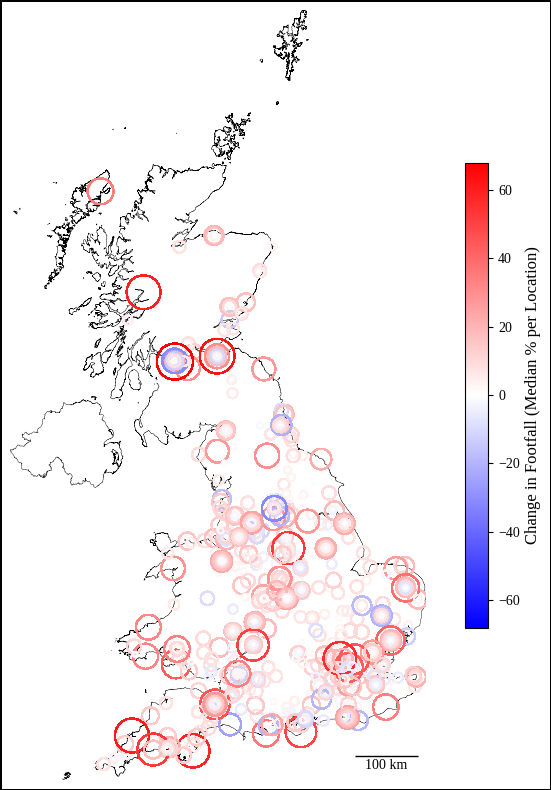

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import FancyArrow

# ensure gdf_centroids is defined and has a 'median' column
# prepare sizes
sizes = gdf_centroids['median'].abs() * 10

# normalize for colormap with 0 at the center
norm = plt.Normalize(vmin=-abs(gdf_centroids['median'].max()), vmax=abs(gdf_centroids['median'].max()))
cmap = cm.get_cmap('bwr')
color_vals = cmap(norm(gdf_centroids['median']))

# plotting
fig, ax = plt.subplots(figsize=(10, 10))

# assuming uk_boundary is defined and contains the UK boundaries
uk_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.3)

# get centroid coordinates
x = gdf_centroids.geometry.x
y = gdf_centroids.geometry.y

# scatter with no fill and colored borders
scatter = ax.scatter(
    x, y,
    s=sizes,
    facecolors='none',
    edgecolors=color_vals,
    linewidth=1
)

# define the UK boundary coordinates (if not already defined)
minx, miny, maxx, maxy = uk_boundary.total_bounds

# add colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)
cbar.set_label('Change in Footfall (Median % per Location)', fontsize=12, family='Tinos for Powerline')  # Font for Powerline

# zoom to UK extent
ax.set_xlim(minx - 0.01, maxx + 0.01)
ax.set_ylim(miny - 0.01, maxy + 0.01)

# hide axes
plt.axis('off')

# add a black border around the plot
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(2)

# add scale bar (1 km scale, adjust size as needed)
scalebar = AnchoredSizeBar(
    transform=ax.transData, 
    size=100000,  # length of scale bar (100 km)
    label='100 km', 
    loc='lower right', 
    frameon=False, 
    size_vertical=1, 
    pad=0.5, 
    color='black'
)
ax.add_artist(scalebar)

# show plot
plt.show()

fig.savefig('locs.png', dpi=500, bbox_inches='tight')

Since points are concentrated, a hexbin map can aggregate nearby locations into hexagonal cells, revealing clearer spatial patterns in temperature sensitivity while reducing visual overlap.

Let's see:

/tmp/ipykernel_3911191/1693317280.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return hexgrid[hexgrid.intersects(gdf.unary_union)]


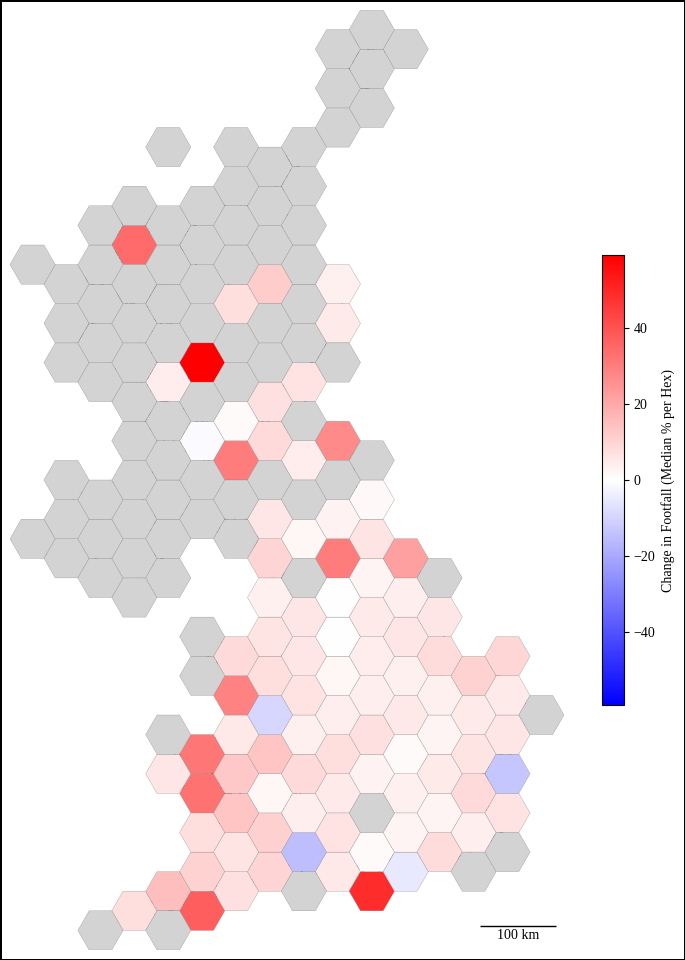

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
import pandas as pd

# ---------------------------
# function to create hex grid
# ---------------------------
def create_hex_grid(gdf, hex_size):
    minx, miny, maxx, maxy = gdf.total_bounds
    dx = 3/2 * hex_size
    dy = np.sqrt(3) * hex_size

    cols = int((maxx - minx) / dx) + 3
    rows = int((maxy - miny) / dy) + 3

    hexes = []
    for row in range(rows):
        for col in range(cols):
            x_offset = minx + col * dx
            y_offset = miny + row * dy
            if col % 2 == 1:
                y_offset += dy / 2

            hexagon = Polygon([
                (x_offset + hex_size * np.cos(theta), y_offset + hex_size * np.sin(theta))
                for theta in np.linspace(0, 2 * np.pi, 7)
            ])
            hexes.append(hexagon)

    hexgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries(hexes), crs=gdf.crs)
    return hexgrid[hexgrid.intersects(gdf.unary_union)]

# ---------------------------
# data preparation
# ---------------------------
# reproject to British National Grid (meters)
gdf_centroids = gdf_centroids.to_crs(epsg=27700)
uk_boundary = uk_boundary.to_crs(epsg=27700)

# ensure 'median' is numeric
gdf_centroids['median'] = pd.to_numeric(gdf_centroids['median'], errors='coerce')
gdf_centroids = gdf_centroids.dropna(subset=['median'])

# create hex grid
hex_size = 30000  # 30 km
hex_grid = create_hex_grid(uk_boundary, hex_size)

# ---------------------------
# aggregate median footfall per hex
# ---------------------------
joined = gpd.sjoin(gdf_centroids, hex_grid, how='left', predicate='within')
median_vals = joined.groupby('index_right')['median'].mean()

hex_grid['median'] = np.nan
hex_grid.loc[median_vals.index, 'median'] = median_vals.values

# ---------------------------
# plotting
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# UK boundary outline
uk_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# normalize data for colormap to center at 0
norm = plt.Normalize(vmin=-abs(hex_grid['median'].max()), vmax=abs(hex_grid['median'].max()))

# plot hexes with 'bwr' colormap
hex_grid.plot(
    ax=ax,
    column='median',
    cmap='bwr',
    edgecolor='grey',
    linewidth=0.2,
    norm=norm,  # apply the normalization
    missing_kwds={'color': 'lightgrey'}  # grey for hexes with no data
)

# colorbar
sm = plt.cm.ScalarMappable(
    cmap='bwr',
    norm=norm
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)  # Adjusted padding
cbar.set_label('Change in Footfall (Median % per Hex)')

# formatting
ax.set_xlim(hex_grid.total_bounds[[0, 2]])
ax.set_ylim(hex_grid.total_bounds[[1, 3]])
ax.set_aspect('equal')
plt.axis('off')

# add a black border around the plot
fig.patch.set_edgecolor('black')  # black border color
fig.patch.set_linewidth(2)  # border thickness

# add scale bar (1 km scale, adjust size as needed)
scalebar = AnchoredSizeBar(
    transform=ax.transData, 
    size=100000,  # length of scale bar (100 km)
    label='100 km', 
    loc='lower right', 
    frameon=False, 
    size_vertical=1, 
    pad=0.5, 
    color='black'
)
ax.add_artist(scalebar)

# adjust layout to ensure proper space for the border and colorbar
plt.subplots_adjust(left=0.1, right=0.85, top=0.99, bottom=0.05)  # manually adjust margins

plt.show()

fig.savefig('hex.png', dpi=500, bbox_inches='tight')
